In [2]:
library(tidyverse)

## 릿지 회귀
- 모델의 모든 변수를 유지하면서도, 덜 영향력 있는 변수가 생성할 수 있는 노이즈를 줄여야 한다고 생각하는 경우

### 릿지 추정량 : 
$
\beta^{R} = \sum(y_i - \beta_0 - \sum \beta_j x_ij )^2 + \lambda \sum beta^2_j = argmin[RSS + \lambda \sum \beta^2_j]
$
- $\beta_j$의 제곱합으로 penalty를 부여, 전체적으로 $\beta_j$를 수축시키는 효과 발생 (상수항 제외)
- 최소제곱추정량에 penalty를 주는 것 ($RSS = y_i - {\hat y}_i$)
- $\lambda$는 K-fold CV로 결정
- $\lambda$가 0일때 : 릿지추정량 = LSE추정량, $\lambda$가 증가함에 따라 추정량은 0으로 수렴
- LSE는 설명변수의 scale에 영향을 받지 않음. 하지만 릿지회귀는 $\lambda$때문에 scale에 크게 의존
- 따라서 릿지회귀 적합 전, 설명변수를 표준화할 필요

- **단점 : $\beta$값들을 수축 시키지만, 정확하게 0을 만들지 못함**




In [57]:
library(glmnet)
library(ISLR)

In [58]:
data(Hitters)
Hitters <- na.omit(Hitters)

In [59]:
y <- Hitters$Salary
x <- model.matrix(Salary ~ ., Hitters)[, -1]

- alpha : 0을쓰면 릿지, 1을쓰면 라쏘
- glmnet은 자동으로 변수를 표준화 (표준화 안하려면 standardize = F)

In [116]:
ridge.mod <- glmnet(x, y, alpha = 0, lambda = 10^seq(10, -2, length = 100))

In [117]:
set.seed(1)
train <- sort(sample(1:nrow(Hitters), 132))
test <- setdiff(1:nrow(Hitters), train)

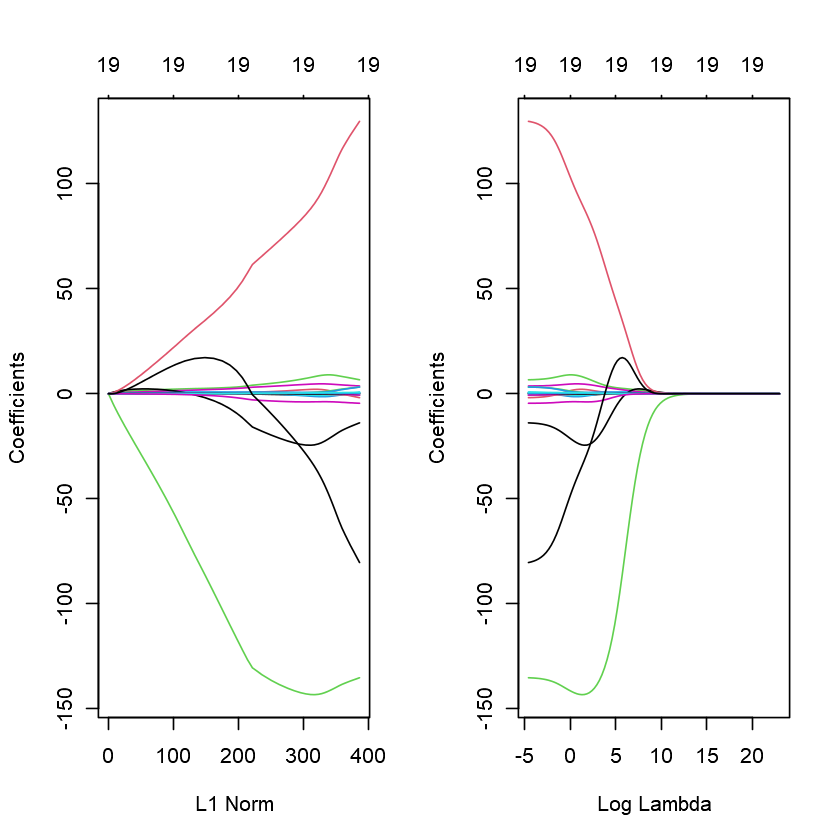

In [131]:
ridge.mod <- glmnet(x[train,], y[train], 
                    alpha = 0, lambda = 10^seq(10, -2, length = 100))
par(mfrow = c(1, 2))
ridge.mod %>% plot
ridge.mod %>% plot(xvar = "lambda")

- s = lambda

In [51]:
ridge.pred <- predict(ridge.mod, s = 4,
                      newx = x[test,])
mean((ridge.pred - y.test)^2)

[1] 139839.6

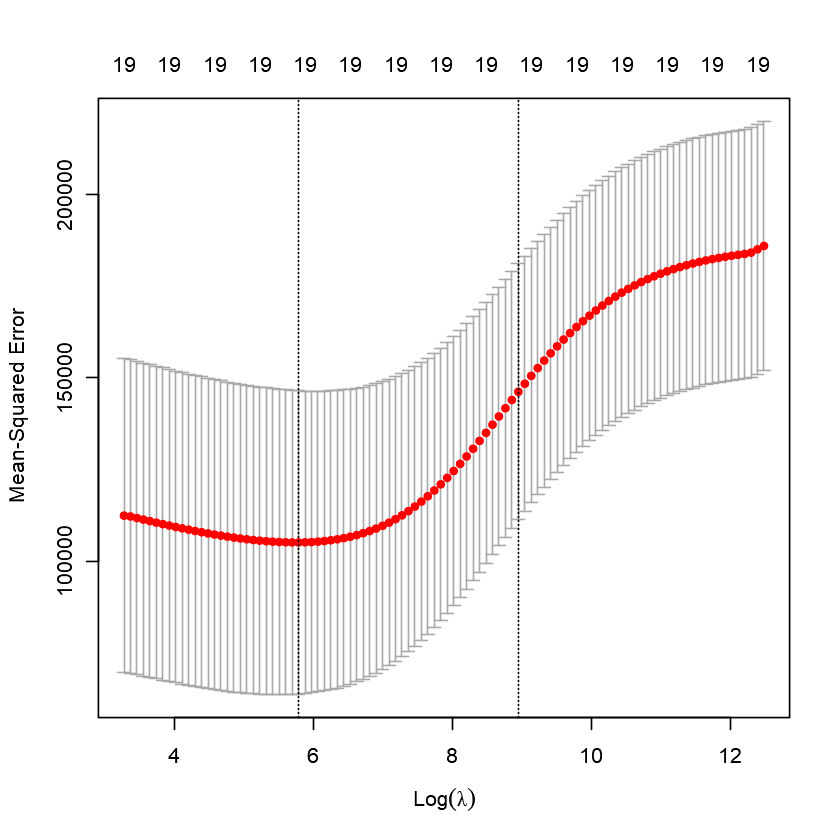

In [63]:
# Select the best lambda using K-fold cv
set.seed(1)
cv.out <- cv.glmnet(x[train,], y[train], alpha = 0)
plot(cv.out)

- 수직점선은 최소 MSE의 1 표준 오차 이내의 MSE
- 상단의 숫자는 모델의 0이 아닌 변수 수
- 릿지회귀는 모든 변수를 정확히 0으로 만들지 않으므로, 모든 변수가 유지

In [132]:
(best.lambda <- cv.out$lambda.min)

ridge.pred <- predict(ridge.mod, s = best.lambda, newx = x[test, ])
mean((ridge.pred - y.test) ^ 2)

[1] 326.1406

[1] 140032.5

- 최적의 $\lambda$값과 릿지회귀 계수

In [137]:
out <- glmnet(x, y, alpha = 0)
predict(out, type = "coefficients", s = best.lambda)

20 x 1 sparse Matrix of class "dgCMatrix"
                      s1
(Intercept)  15.44834992
AtBat         0.07716945
Hits          0.85906253
HmRun         0.60120338
Runs          1.06366687
RBI           0.87936073
Walks         1.62437580
Years         1.35296285
CAtBat        0.01134998
CHits         0.05746377
CHmRun        0.40678422
CRuns         0.11455696
CRBI          0.12115916
CWalks        0.05299953
LeagueN      22.08942756
DivisionW   -79.03490992
PutOuts       0.16618830
Assists       0.02941513
Errors       -1.36075645
NewLeagueN    9.12528397

### 라쏘 회귀
- 데이터 세트에 많은 변수가 있는 경우 라쏘를 사용하여 가장 크고 일관된 신호를 가진 변수를 식별하고 추출
- 라쏘 패널티로 전환하면 모델이 향상될 뿐만 아니라 자동화된 기능 선택도 수행

### 라쏘 추정량 : 
$ 
\beta^L = \sum(y_i - \beta_0 - \sum \beta_j x_ij )^2 + \lambda \sum |\beta_j| = argmin[RSS + \lambda \sum |\beta_j|]
$

- $\lambda$가 0일때 : 라쏘 추정량 = LSE 추정량
- $\lambda$가 충분히 클 때 : 모든 계수 추정량 = 0 => 영모형
- $\lambda$값은 K-fold CV로 결정
- 라소회귀 적합 전 설명변수를 표준화 할 필요

- 모든 $\lambda$값에 대해, 릿지와 라쏘 추정량이 동일한 값을 가지는 s가 존재

- 릿지의 경우 LSE를 일정한 비율 ($1 + \lambda$)로 수축
- 라쏘의 경우 LSE를 일정한 양 $\lambda / 2$만큼 수축, 절댓값이 $\lambda / 2$보다 작은 LSE는 0으로

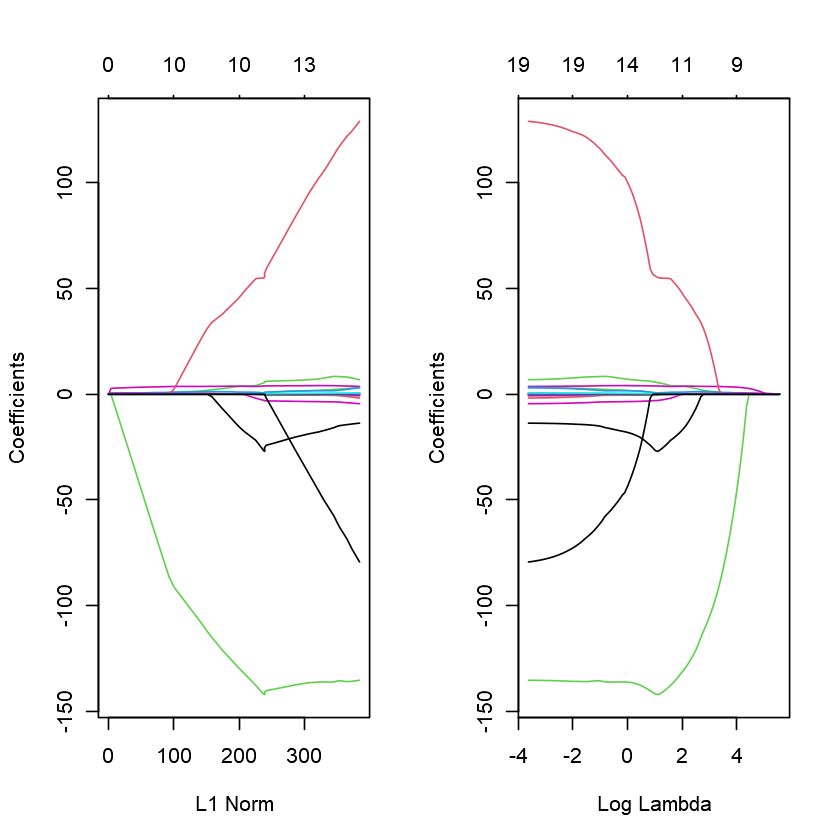

In [139]:
lasso.mod <- glmnet(x[train,], y[train], 
                    alpha = 1, lamgbda = 10^seq(10, -2, length = 100))
par(mfrow = c(1, 2))
lasso.mod %>% plot
lasso.mod %>% plot(xvar = "lambda")

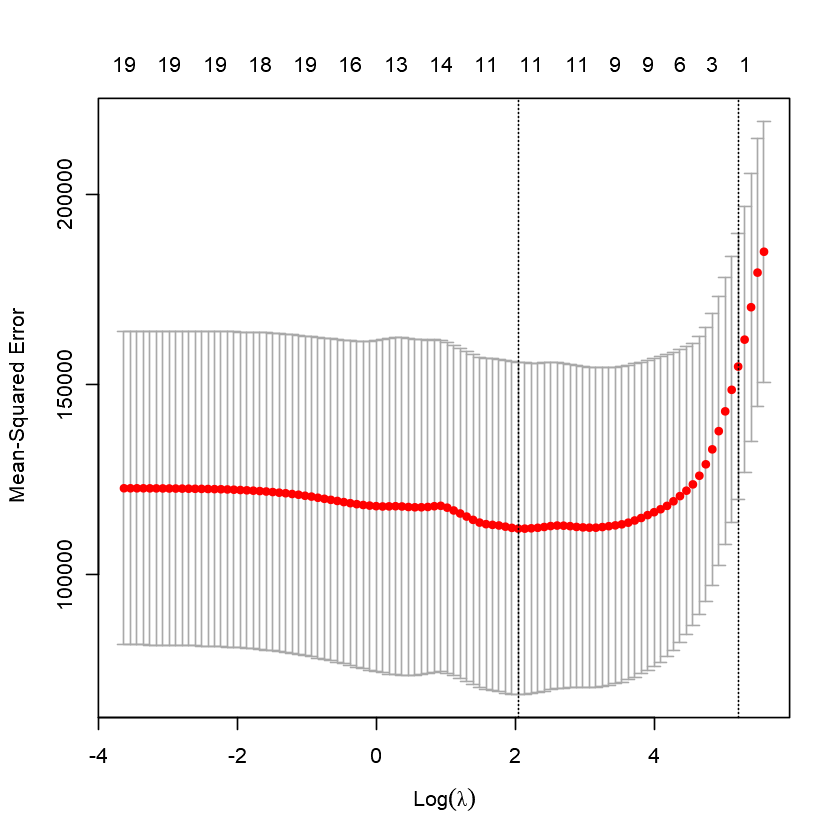

In [142]:
set.seed(1)
cv.out <- cv.glmnet(x[train,], y[train], alpha = 1)
plot(cv.out

- 라쏘회귀는 변수의 수가 감소 (일부 변수들이 0이 됨)

In [145]:
best.lambda <- cv.out$lambda.min
log(best.lambda)

[1] 2.042721

In [146]:
lasso.pred <- predict(lasso.mod, s = best.lambda, newx = x[test,])
mean((lasso.pred - y[test])^2)

[1] 144422.6

In [148]:
out <- glmnet(x, y, alpha = 1)
coef.lasso <- predict(out, type = "coefficients", s = best.lambda)
coef.lasso

20 x 1 sparse Matrix of class "dgCMatrix"
                       s1
(Intercept)    9.48789587
AtBat         -0.18970484
Hits           2.59347606
HmRun          .         
Runs           .         
RBI            .         
Walks          2.35494439
Years         -1.50965810
CAtBat         .         
CHits          .         
CHmRun         0.05168855
CRuns          0.22970597
CRBI           0.41769331
CWalks         .         
LeagueN       23.86861384
DivisionW   -117.88741979
PutOuts        0.24162555
Assists        .         
Errors        -0.98022287
NewLeagueN     .         

### 엘라스틱 넷
- 릿지와 라쏘를 결합
- 라쏘 모델이 기능 선택을 수행하지만 두 개의 강력한 상관 관계가 0으로 푸시되면 하나는완전히 0으로 푸시되고 다른 하나는 모델에 남아 있을 수 있다.
- 하나의 변수가 포함되고 제외되는 과정이 그다지 체계적이지 못하다.
- 대조적으로, 릿지 모델은 상관된 기능을 함께 체계적으로 처리하는 데 조금 더 효과적 - - 따라서, Elastic Net Penalty의 장점은 라쏘 패널티의 특징 선택 특성과 함께 릿지 패널티를 통해 효과적인 정규화를 가능하게 한다는 점이다.

In [153]:
library(caret)
library(recipes)

set.seed(123)

cv_glmnet <- train(
  x = x[train,],
  y = y[train],
  method = "glmnet",
  preProc = c("zv", "center", "scale"),
  trControl = trainControl(method = "cv", number = 10),
  tuneLength = 10
)

In [154]:
cv_glmnet$bestTune

,alpha,lambda
,<dbl>,<dbl>
8,0.1,42.91575


In [155]:
cv_glmnet$results %>%
  filter(alpha == cv_glmnet$bestTune$alpha, lambda == cv_glmnet$bestTune$lambda)

alpha,lambda,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.1,42.91575,300.081,0.5515855,218.1749,127.2883,0.2420447,54.69915


In [174]:
out <- glmnet(x, y, 
              alpha = cv_glmnet$bestTune$alpha, 
              lambda = cv_glmnet$beestTune$lambda)

In [175]:
elastic.lasso <- predict(out, type = "coefficients", s = best.lambda)
elastic.lasso

20 x 1 sparse Matrix of class "dgCMatrix"
                       s1
(Intercept)  124.06677234
AtBat         -1.27601337
Hits           4.69238509
HmRun          .         
Runs           0.07512596
RBI            0.18436419
Walks          4.58599118
Years        -10.90151736
CAtBat        -0.01695175
CHits          0.14857543
CHmRun         0.73097023
CRuns          0.49933279
CRBI           0.30864086
CWalks        -0.48159691
LeagueN       49.83908743
DivisionW   -123.94386512
PutOuts        0.27276024
Assists        0.22022830
Errors        -3.40878394
NewLeagueN   -16.98491123

In [159]:
elastic.pred <- predict(cv_glmnet, x[test, ])
mean((elastic.pred - y[test])^2)

[1] 142392.6

- 릿지 : $\lambda$가 증가 : 계수추정량 0으로 수렴
- 라쏘 : $\lambda$가 충분히 클 때 : 계수추정량 = 0 => 영모형

- Test MSE : $\lambda$가 증가 => 적합의 유연성 감소 = > Test MSE의 편향 증가, 분산 감소
- MSE가 최소가 되게하는 특정 $\lambda$가 존재
- p $\approx$ n, p > n => 작은 편향, 큰 분산 => 릿지나 라쏘가 좋음
- 모든 변수가 반응변수와 관련 => 릿지 > 라쏘
- 일부 변수만 반응변수와 관련 => 릿지 < 라쏘

## 차원 축소 모형

### 주성분 분석 PCA
- 상관관계가 있는 고차원 자료를 자료의 변동을 최대한 보존하는 저차원 자료 변환법
- n $\times$ p의 차원을 줄임
- 고윳값이 높은 순으로 정렬해서, 높은 고윳값을 가진 고유 벡터만으로 데이터를 복원
- 누적 기여율이 85%이상이면 주성분의 수로 결정 가능

- PC loading : 주성분 계수
- PC scores : 주성분 변수

### 주성분 회귀 PCR
- M개의 주성분 변수를 설명 변수로
- 반응변수와 관련된 대부분의 정보는 주성분 변수에 포함됨, 그리고 M개의 주성분 계수들을 추정함으로써 과적합을 방지
- 주성분의 개수 M은 K-fold CV를 통해 결정, **PCR전 변수의 표준화 필요**

- **모든 변수가 반응변수와 연관 => 주성분 회귀 효과적**
- **오직 2개만이 반응변수와 연관 => 주성분 회귀 효과X (주성분은 모든 설명변수의 선형결합 형태, 모든 설명변수를 일정부분 반영)**
- **일부의 주성분이 반응변수와 연관 => 릿지 > 라쏘 & PCR**

In [177]:
library(pls)

Data: 	X dimension: 132 19 
	Y dimension: 132 1
Fit method: svdpc
Number of components considered: 19

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV           428.6    326.2    331.6    321.8    325.5    320.3    324.1
adjCV        428.6    325.7    330.9    320.8    324.6    319.3    323.0
       7 comps  8 comps  9 comps  10 comps  11 comps  12 comps  13 comps
CV       327.1    325.8    326.7     330.6     331.4     334.4     335.3
adjCV    325.8    324.4    324.9     328.7     329.4     332.3     332.9
       14 comps  15 comps  16 comps  17 comps  18 comps  19 comps
CV        336.6     339.4     340.6     345.8     352.5     344.4
adjCV     334.2     336.8     337.7     342.6     348.7     340.6

TRAINING: % variance explained
        1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps  8 comps
X         39.23    61.27    71.67     80.5    85.62    89.69    92.95    95.30
Salary    4

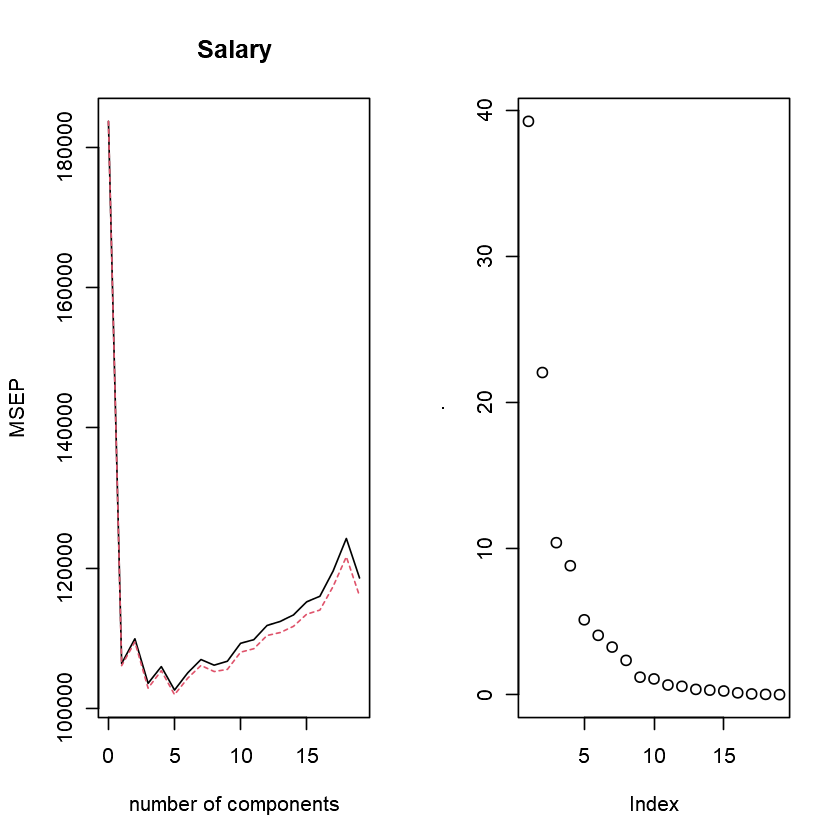

In [292]:
# Fit PCR with training / test data
set.seed(1)
pcr.fit <- pcr(Salary ~., data = Hitters, subset = train, scale = T,
               validation = "CV")
par(mfrow = c(1, 2))
validationplot(pcr.fit, val.type = "MSEP")
summary(pcr.fit)
pls::explvar(pcr.fit) %>% plot

In [203]:
pcr.pred <- predict(pcr.fit, newdata = x[test,], ncomp = 5)
mean((pcr.pred - y.test)^2)

[1] 145069.1

In [204]:
pcr.fit <- pcr(y ~ x, scale = T, ncomp = 5)
summary(pcr.fit)

Data: 	X dimension: 263 19 
	Y dimension: 263 1
Fit method: svdpc
Number of components considered: 5
TRAINING: % variance explained
   1 comps  2 comps  3 comps  4 comps  5 comps
X    38.31    60.16    70.84    79.03    84.29
y    40.63    41.58    42.17    43.22    44.90


### PLS 
- PCR은 비지도학습, PLS는 지도학습
- PLS는 PCR과 비교하여 반응벼수와 더 관련이 있음
- M은 K-fold CV로 결정, PLS전 변수들에 대한 표준화 필요

Data: 	X dimension: 132 19 
	Y dimension: 132 1
Fit method: kernelpls
Number of components considered: 19

VALIDATION: RMSEP
Cross-validated using 10 random segments.
       (Intercept)  1 comps  2 comps  3 comps  4 comps  5 comps  6 comps
CV           428.6    324.4    327.5    325.1    332.3    335.4    337.6
adjCV        428.6    323.9    325.9    323.6    330.4    333.0    334.6
       7 comps  8 comps  9 comps  10 comps  11 comps  12 comps  13 comps
CV       339.2    345.4    343.0     343.9     342.3     348.9     348.8
adjCV    336.4    342.1    339.9     341.0     339.2     345.3     345.4
       14 comps  15 comps  16 comps  17 comps  18 comps  19 comps
CV        352.4     350.9     352.6     342.5     341.8     344.4
adjCV     348.1     346.7     348.4     339.0     338.3     340.6

TRAINING: % variance explained
        1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps  8 comps
X         39.03    48.78    60.06    74.97    78.19    80.72    87.53    90.46
Salary 

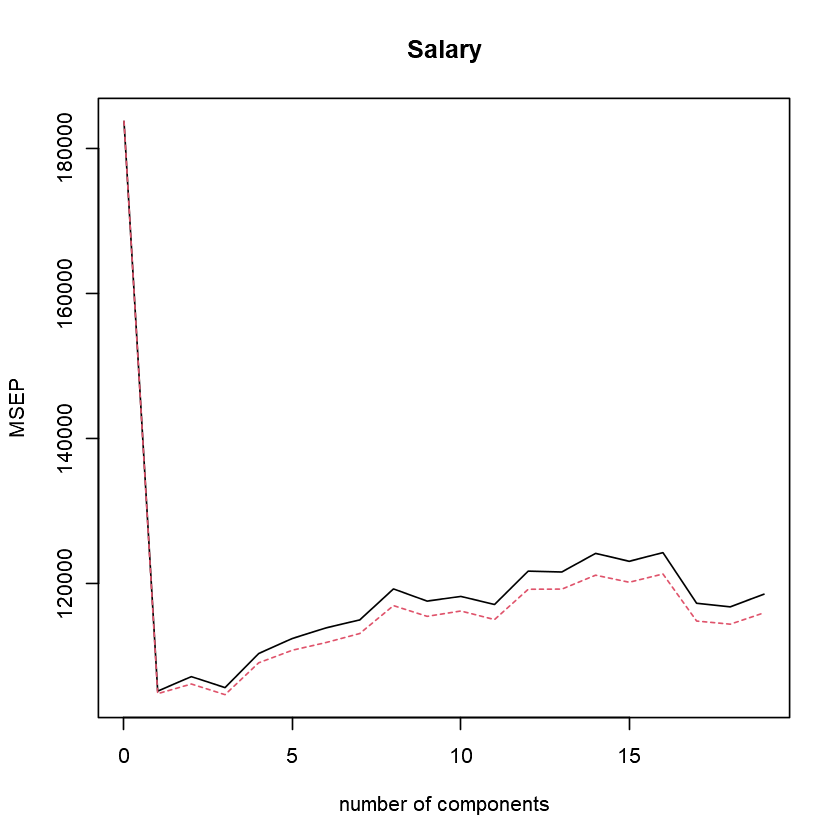

In [217]:
set.seed(1)
pls.fit <- plsr(Salary ~., data = Hitters, subset = train, scale = T,
                validation = "CV")
summary(pls.fit)
validationplot(pls.fit, val.type= "MSE")

In [213]:
pls.pred <- predict(pls.fit, x[test, ], ncomp = 7)
mean((pls.pred - y.test) ^ 2)

[1] 143333.4

In [214]:
pls.fit <- plsr(Salary ~., data = Hitters, scale = T, ncomp = 7)
summary(pls.fit)

Data: 	X dimension: 263 19 
	Y dimension: 263 1
Fit method: kernelpls
Number of components considered: 7
TRAINING: % variance explained
        1 comps  2 comps  3 comps  4 comps  5 comps  6 comps  7 comps
X         38.08    51.03    65.98    73.93    78.63    84.26    88.17
Salary    43.05    46.40    47.72    48.71    50.53    51.66    52.34


## 다항회귀 / 비선형회귀
### 다항식 회귀 (Polynomial)
- $y_i = \beta_0 + \beta_1 x_i + \beta_2 x^2_i + ... \beta_d x^d_i + \epsilon_i$
- 로지스틱도 가능

In [239]:
attach(Wage)

In [291]:
fit <- lm(wage ~ age, data = Wage)
coef(summary(fit))

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),81.7047354,2.84624224,28.70618,2.543375e-160
age,0.7072759,0.06475113,10.92299,2.900778e-27


In [245]:
fit <- lm(wage ~ poly(age, 4), data = Wage)
coef(summary(fit)) # 직교 다항식

fit1 <- lm(wage ~ poly(age, 4, raw = T), data = Wage)
coef(summary(fit1))

# poly(age, 4, raw =T)는 아래와 동일
fit2a <- lm(wage ~ age + I(age^2) + I(age^3) + I(age^4), data = Wage)
coef(summary(fit2a))

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),111.70361,0.7287409,153.283015,0.000000e+00
"poly(age, 4)1",447.06785,39.9147851,11.200558,1.484604e-28
"poly(age, 4)2",-478.31581,39.9147851,-11.983424,2.355831e-32
"poly(age, 4)3",125.52169,39.9147851,3.144742,1.678622e-03
"poly(age, 4)4",-77.91118,39.9147851,-1.951938,5.103865e-02


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-1.841542e+02,6.004038e+01,-3.067172,0.0021802539
"poly(age, 4, raw = T)1",2.124552e+01,5.886748e+00,3.609042,0.0003123618
"poly(age, 4, raw = T)2",-5.638593e-01,2.061083e-01,-2.735743,0.0062606446
"poly(age, 4, raw = T)3",6.810688e-03,3.065931e-03,2.221409,0.0263977518
"poly(age, 4, raw = T)4",-3.203830e-05,1.641359e-05,-1.951938,0.0510386498


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-1.841542e+02,6.004038e+01,-3.067172,0.0021802539
age,2.124552e+01,5.886748e+00,3.609042,0.0003123618
I(age^2),-5.638593e-01,2.061083e-01,-2.735743,0.0062606446
I(age^3),6.810688e-03,3.065931e-03,2.221409,0.0263977518
I(age^4),-3.203830e-05,1.641359e-05,-1.951938,0.0510386498


In [250]:
# make plot for degree = 4 polynomial regression
agelims <- range(age) ; age.grid <- seq(agelims[1], agelims[2])

In [256]:
preds <- predict(fit, newdata = list(age = age.grid), se = T)
se.bands <- cbind(preds$fit + 2*preds$se.fit, preds$fit - 2*preds$se.fit) # 95% CI

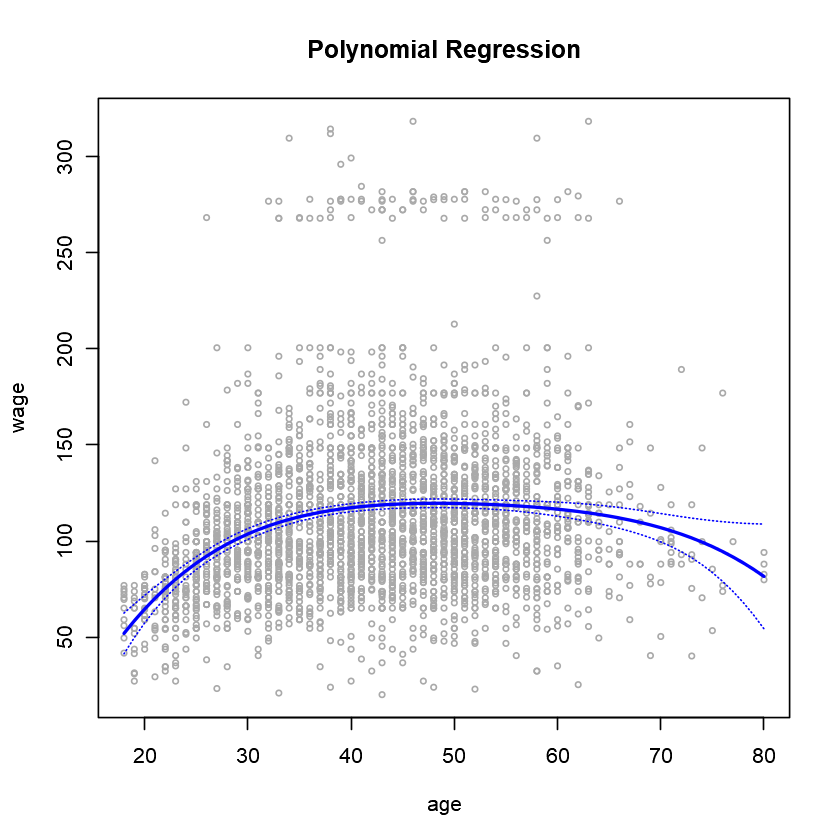

In [247]:
plot(age, wage, xlim = agelims, cex = 0.5, 
     col = "dark grey", main = "Polynomial Regression")
lines(age.grid, preds$fit, lwd = 2, col="blue")
lines(age.grid, se.bands[,1], lwd = 1, col = "blue", lty = 3)
lines(age.grid, se.bands[,2], lwd = 1, col = "blue", lty = 3)

In [261]:
# Select the degree of the polynomial regression
fit.1 <- lm(wage ~ age, data = Wage)
fit.2 <- lm(wage ~ poly(age, 2), data = Wage)
fit.3 <- lm(wage ~ poly(age, 3), data = Wage)
fit.4 <- lm(wage ~ poly(age, 4), data = Wage)
fit.5 <- lm(wage ~ poly(age, 5), data = Wage)

anova(fit.1, fit.2, fit.3, fit.4, fit.5) 
coef(summary(fit.5)) %>% print # 3차 제곱항까지 유의함

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2998,5022216,NA,NA,NA,NA
2,2997,4793430,1,228786.010,143.5931074,2.367734e-32
3,2996,4777674,1,15755.694,9.8887559,1.679213e-03
4,2995,4771604,1,6070.152,3.8098134,5.104623e-02
5,2994,4770322,1,1282.563,0.8049758,3.696820e-01


                Estimate Std. Error     t value     Pr(>|t|)
(Intercept)    111.70361  0.7287647 153.2780243 0.000000e+00
poly(age, 5)1  447.06785 39.9160847  11.2001930 1.491111e-28
poly(age, 5)2 -478.31581 39.9160847 -11.9830341 2.367734e-32
poly(age, 5)3  125.52169 39.9160847   3.1446392 1.679213e-03
poly(age, 5)4  -77.91118 39.9160847  -1.9518743 5.104623e-02
poly(age, 5)5  -35.81289 39.9160847  -0.8972045 3.696820e-01


In [264]:
# degree = 4 logistic regression
fit <- glm(I(wage > 250) ~ poly(age, 4), data = Wage, family = binomial)

preds <- predict(fit, newdata = list(age = age.grid), se = T)
pfit <- exp(preds$fit) / (1 + exp(preds$fit)) # 적합값
# preds <- predict(fit, newdata = list(age = age.grid), se = T, type = "response")
# head(pred)

In [266]:
se.bands.logit <- cbind(preds$fit + 2*preds$se.fit, preds$fit - 2*preds$se.fit)
se.bands <- exp(se.bands.logit) / (1 + exp(se.bands.logit)) # 95% CI

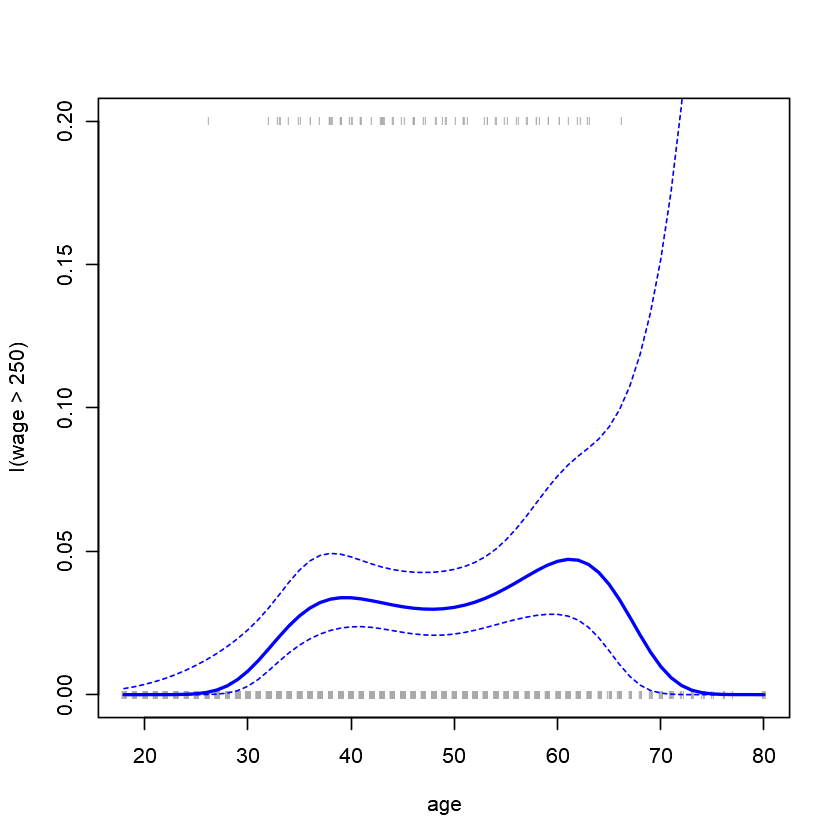

In [269]:
plot(age, I(wage>250), xlim = agelims, type = "n", ylim= c(0,0.2))
points(jitter(age), I(wage>250)/5, cex = 0.5, pch = "l", col = "dark grey")
lines(age.grid, pfit, lwd = 2, col = "blue")
lines(age.grid, se.bands[,1], lwd = 1, col = "blue", lty = 2)
lines(age.grid, se.bands[,2], lwd = 1, col = "blue", lty = 2) # 95% CI

### 계단함수 (Step Function)
- X의 범위를 여러 개의 bin으로 분할하여, 각 bin에 다른 상수를 적합
- 연속형변수를 순서형변수로 변환

In [ ]:
# step function
table(cut(age, 4))
fit1 <- lm(wage ~ cut(age, 4), data = Wage)

## 회귀 스플라인 (Regression Splines)
### 단일 매듭 조각별 다항식 회귀
- **c : 컷 포인트**
1. Piecewise cubic (3차항)

$y_i = \beta_01 + \beta_11 x_i + \beta_21 x^2_i + \beta_31 x^3_i + \epsilon_i$ ( if $x_i < c)
$
$y_i = \beta_02 + \beta_12 x_i + \beta_22 x^2_i + \beta_32 x^3_i + \epsilon_i$ ( if $x_i \geq c)
$
- parameter 개수가 (4+4) = 8개 => df = 8
2. Continuous piecewise cubic (불연속인 점을 연속적으로)
- piecewise cubic에서 한 개의 제약 추가, 1차 도함수의 연속성
- $x_i$ = c에서 연속, but 부자연스러움, 한 개의 제약으로 자유도 8-1 = 7
3. Cupic spline
- 1차, 2차 도함수의 연속성 => 자연스러운 연결
- 두 개의 제약추가로 자유도 df = 8-1-2 = 5
4. Linear spline : 선형함수 두 개로 적합하고 연속성 조건을 만족

### k개 매듭 조각별 다항식 회귀
- d차 polynomial이면 d-1차 도함수까지 연속으로
- k개의 cutpoint
- 기저함수 (basis function) : $b_1 ... b_{K+3}$

$ y_i = \beta_0 + beta_1 b_1 (x_i) + ... \beta_{K+3} b_{K+3} (x_i) + \epsilon_i
$
- cubic polynomial에 대한 basis, 즉 $x, x^2, x^3$과 knot당 하나의 기저함수를 추가
- 즉 k+3개의 계수 추정치를 가지는 모델을 least squares로 적합
- k개의 knot에서 원래 함수와 1차 2차 도함수까지 모두 연속으로
- 상수항까지 포함해서 df = k+4가 사용됨

In [294]:
# Regresison splines
library(splines)
fit <- lm(wage ~ bs(age, knots = c(25, 40, 60)), data = Wage)
pred <- predict(fit, newdata = list(age = age.grid), se = T)

### 자연 삼차 스플라인
- spline의 양 끝단에서 선형이라는 추가적인 제약이 있어, 더 안정적인 추정치를 제공

### Knot의 개수와 위치
- 10-folds CV를 통해서 최소의 test MSE를 주는 k값 (knot의 개수)를 선택
- knot의 개수가 결정되면 분위수에 대응하는 수에 knot를 위치

In [293]:
fit2 <- lm(wage ~ ns(age, df = 4), data = Wage)
pred2 <- predict(fit2, newdata = list(age = age.grid), se = T)

### 평활 스플라인 (Smoothing Spline)
- RSS = $\sum (y_i - g(x_i))^2$가 작고 평활한 함수
- $\hat{g}(x_i) = argmin[\sum (y_i - g(x_i))^2 + \lambda \int g^{''}(t)^2 dt]
$ = 손실함수 + g의 변동성에 penalty를 주는 항
- $g^{''}(t)$는 함수의 이차 도함수 = roughness에 대한 측도 (t근방에서 꾸불꾸불하면 $g^{''}$의 절댓값은 커지고, 평평해지면 0에 가까움
- $\int g^{''}(t)^2 dt$는 총 변화에 대한 측도, $\lambda$가 커지면 $\hat{g}$의 smoothness는 증가, 작아지면 감소
- $\hat{g}(x_i)$를 실제 구하면, k개 매듭 조각별 다항식 회귀가 되고, 1차 2차 도함수 모두 knot에서 연속이고, 극단적인 knot이외 영역에서는 선형

- 훈련데이터로 $\lambda$추정, $\lambda$는 평활곡선의 roughness를 조정
- $\lambda$가 0에서 Inf로 증가 => 자유도가 n -< 2로 감소 (직선)
- LOOCV로 $RSS_{CV}$가 최소가 되게하는 $\lambda$값을 선택

- $RSS_{CV}$ : i번째 관측치를 제외한 훈련데이터로 추정한 값

Warning message in smooth.spline(age, wage, cv = T):
"cross-validation with non-unique 'x' values seems doubtful"


[1] 16.00237

[1] 6.794596

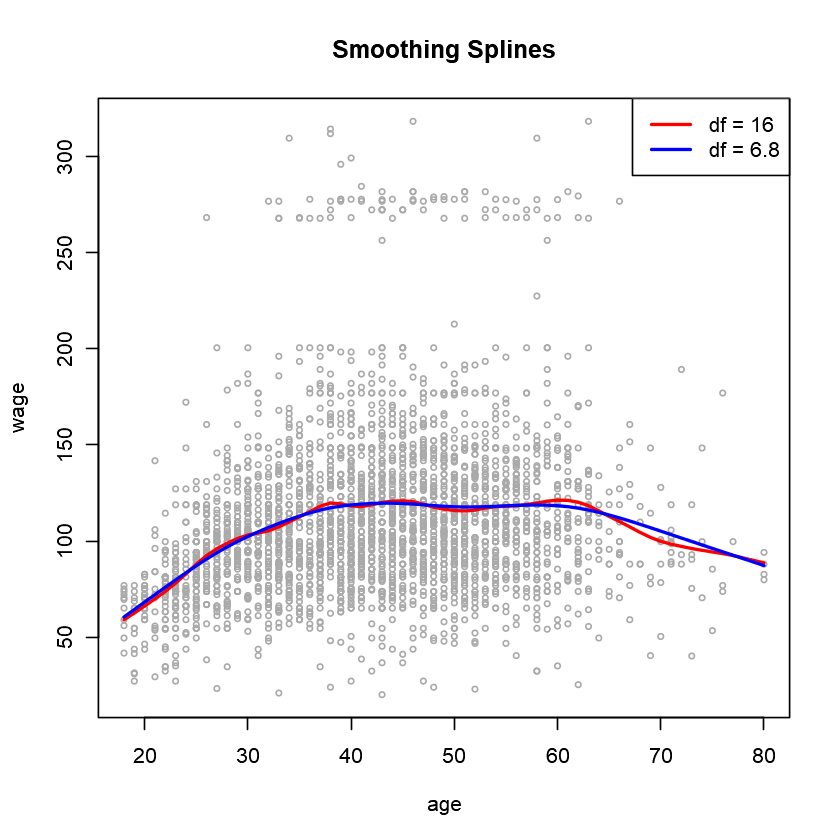

In [295]:
plot(age, wage, xlim = agelims, 
     cex = 0.5, col = "darkgrey", main = "Smoothing Splines")
fit <- smooth.spline(age, wage , df = 16)
fit2 <- smooth.spline(age, wage, cv = T)
fit$df ; fit2$df

lines(fit, col = "red", lwd = 2)
lines(fit2, col = "blue", lwd = 2)
legend("topright", legend =c("df = 16", "df = 6.8"), col = c("red", "blue"),
                             lty = 1, lwd = 2)

### 국소회귀 (Local Regression)
- 근처의 관측값만을 사용해서 target point를 적합 -> target point와 제일 가까운 점들에 가중치를 적용 (가장 가까운 점에는 높은 가중치, 가장 먼 점에는 0)
- 가중함수 K : 다양한 방법 (linear, quadratic으로 적합)
- Span : s = k / n, 평활곡선의 tuning parameter처럼 유연성을 조절 (목표점 근처의 몇개의 점을 활용할 것인가?)
- s가 작을수록 적합은 local하고 꾸불꾸불, 아주 크면 훈련데이터 전체를 사용하여 global
- K-fold CV, LOOCV로 s 선택 가능

In [303]:
fit <- loess(wage ~ age, span = 0.2, data = Wage)
fit2 <- loess(wage ~ age, span = 0.5, data = Wage)
pred <- predict(fit, newdata = data.frame(age = age.grid))
pred2 <- predict(fit2, newdata = data.frame(age = age.grid))

### 일반화 가법 모델 (GAM)
- $X_1 ... X_p$를 통하여 유연하게 Y를 예측, 다항회귀의 확장개념
- 비선형의 함수를 각각의 변수에 대해 추가
$f_j(x_ij) = \beta_0 + f_1(x_i1) + f_2(x_i2) + ... f_p(x_ip) + \epsilon_i = \beta_0 + \sum f_j(x_ij) + \epsilon_i
$

$f_j(x_ij) : 아무 비선형 방식 모델
$

- 장점 : 선형 모델이나, 비선형 모델들을 가법으로 적합하여, 반응변수와 설명변수간 비선형 관계까지 커버 => 더 좋은 적합
- 단점 : 모형의 addictive해야 됨. 하지만 선형회귀처럼 교호작용항 추가 가능
- 로지스틱 적용 가능

In [309]:
library(gam)

# fit Splines
gam1 <- lm(wage ~ ns(year, df = 4) + ns(age, df =5) + education, data = Wage)

- s : 스플라인, lo : 국소

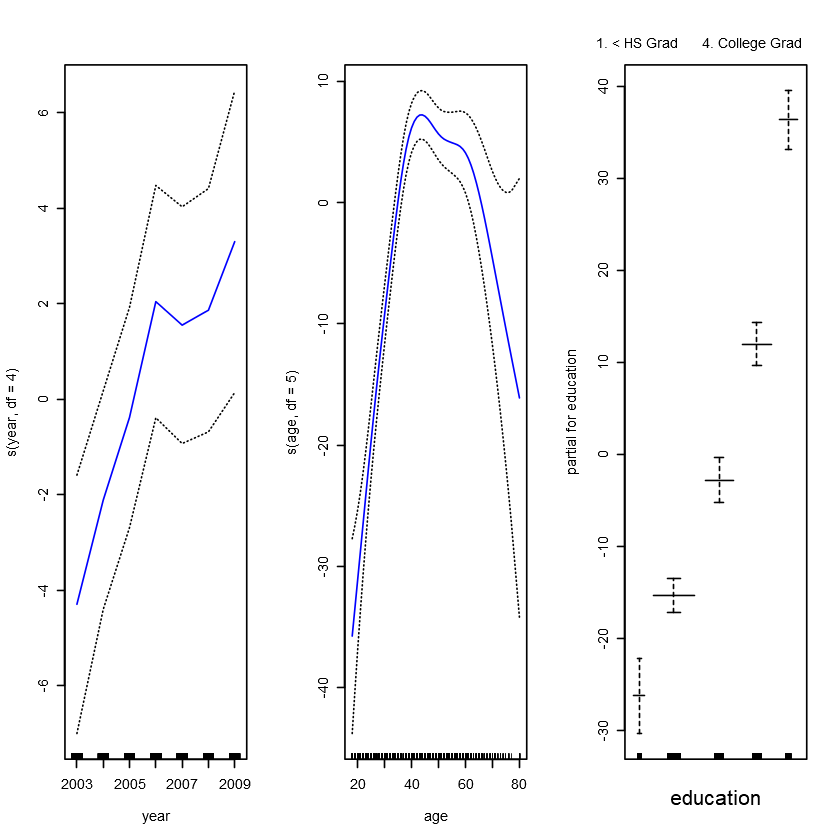

In [310]:
gam.m3 <- gam(wage ~ s(year, df = 4) + s(age, df =5) + education, data = Wage)
par(mfrow = c(1,3))
plot(gam.m3, se = T, col = "blue")

In [312]:
gam.m1 <- gam(wage ~ s(age, 5) + education, data = Wage)
gam.m2 <- gam(wage ~ year + s(age, 5) + education, data = Wage)
gam.m3 <- gam(wage ~ s(year, 4) + s(age, 5) + education, data = Wage)

anova(gam.m1, gam.m2, gam.m3)

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2990,3711731,NA,NA,NA
2,2989,3693842,1.000000,17889.243,0.0001418716
3,2986,3689770,2.999989,4071.134,0.3483897105


In [324]:
# use local regression
gam.lo <- gam(wage ~ s(year, 4) + lo(age, span = 0.7) + education, data = Wage)

In [325]:
# logistic regression GAM
gam.lr <- gam(I(wage > 250) ~ year + s(age, 5) + education, data = Wage)

In [323]:
gam.lr.s <- gam(I(wage > 250) ~ year + s(age, 5) + education, 
                subset = (education) != "1. < Hs Grad", data = Wage)